# LSTM - Multiclass

In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Layer
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import asarray
from numpy import zeros
from keras.regularizers import L2
import tensorflow.keras.backend as K
import tensorflow as tf

## Dataset Loading and Splitting

Loading the dataset with more preprocessing steps.  We will call it Dataset 1.

In [6]:
df_train1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/train_tweets_LSTM_pre_new.csv')
df_val1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/eval_tweets_LSTM_pre_new.csv')
df_test1 = pd.read_csv('../../data/New dataset/LSTM/preprocessing/test_tweets_LSTM_p_new.csv')

In [7]:
X_train1, y_train1 = df_train1["tweet_text"], df_train1["cyberbullying_type"]
X_val1, y_val1 = df_val1["tweet_text"], df_val1["cyberbullying_type"]
X_test1, y_test1 = df_test1["tweet_text"], df_test1["cyberbullying_type"]

Loading the dataset with less preprocessing steps.
We will call it Dataset 2.

In [8]:
df_train2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/train_tweets_LSTM_no_new.csv')
df_val2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/eval_tweets_LSTM_no_new.csv')
df_test2 = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/test_tweets_LSTM_no_new.csv')

In [9]:
X_train2, y_train2 = df_train2["tweet_text"], df_train2["cyberbullying_type"]
X_val2, y_val2 = df_val2["tweet_text"], df_val2["cyberbullying_type"]
X_test2, y_test2 = df_test2["tweet_text"], df_test2["cyberbullying_type"]

Investigating tweets length distribution of different datasets.

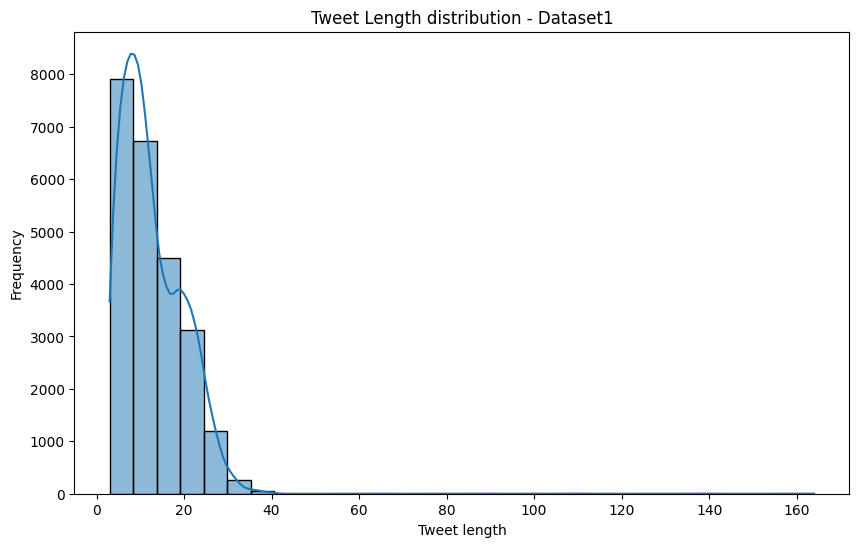

Percentage of tweets longer than 45 tokens: 0.04%


In [10]:
df_train1['tweet_length'] = df_train1['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train1['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution - Dataset1')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

df_train1['text_len'] = [len(text.split()) for text in df_train1.tweet_text]
max_len = 45
count = (df_train1['text_len'] >= max_len).sum() 
total_tweets = len(df_train1)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

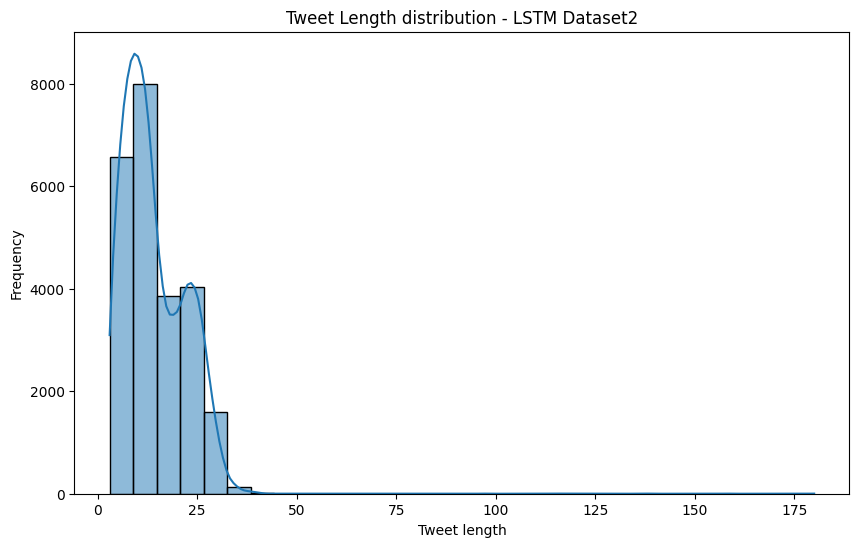

Percentage of tweets longer than 45 tokens: 0.04%


In [11]:
df_train2['tweet_length'] = df_train2['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train2['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution - LSTM Dataset2')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

df_train2['text_len'] = [len(text.split()) for text in df_train2.tweet_text]
max_len = 45
count = (df_train2['text_len'] >= max_len).sum() 
total_tweets = len(df_train2)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

The distribution of the tweet length seems to be very similar. Most tweets are between 5 and 30 tokens long. So we established a threeshold of 45 tokens. Longer tweets are trucated, shorter ones are pre padded.

## Embeddings

We dediced to try different techniques to create our embedding: GloVe 200 dimensions, GloVe 50 dimensions and FastText.

In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y_train1 = label_encoder.fit_transform(y_train1)
y_val1 = label_encoder.transform(y_val1)
y_test1 = label_encoder.transform(y_test1)

#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer1 = Tokenizer()
word_tokenizer1.fit_on_texts(X_train1)

X_train1 = word_tokenizer1.texts_to_sequences(X_train1)
X_test1 = word_tokenizer1.texts_to_sequences(X_test1)
X_val1 = word_tokenizer1.texts_to_sequences(X_val1)

vocab_length1 = len(word_tokenizer1.word_index) + 1

print("The vocaboulary length for Dataset 1 is:", vocab_length1)

X_train1 = pad_sequences(X_train1, padding = 'pre', maxlen = max_len)
X_test1 = pad_sequences(X_test1, padding = 'pre', maxlen = max_len)
X_val1 = pad_sequences(X_val1, padding = 'pre', maxlen = max_len)

The vocaboulary length for Dataset 1 is: 15952


In [13]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y_train2 = label_encoder.fit_transform(y_train2)
y_val2 = label_encoder.transform(y_val2)
y_test2 = label_encoder.transform(y_test2)

#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer2 = Tokenizer()
word_tokenizer2.fit_on_texts(X_train2)

X_train2 = word_tokenizer2.texts_to_sequences(X_train2)
X_test2 = word_tokenizer2.texts_to_sequences(X_test2)
X_val2 = word_tokenizer2.texts_to_sequences(X_val2)

vocab_length2 = len(word_tokenizer2.word_index) + 1

print("The vocaboulary length for Dataset 2 is:", vocab_length2)

X_train2 = pad_sequences(X_train2, padding = 'pre', maxlen = max_len)
X_test2 = pad_sequences(X_test2, padding = 'pre', maxlen = max_len)
X_val2 = pad_sequences(X_val2, padding = 'pre', maxlen = max_len)

The vocaboulary length for Dataset 2 is: 31783


We notice that the vocabulary length of Dataset 2 is bigger: this is normal, as the dataset has undergone fewer preprocessing steps.

Depending on how we want to create our embeddings, we run one of the following cells.

### GloVe

In [10]:
def glove(vocab_length, dim, word_tokenizer):
    # Load GloVe word embeddings and create a dictionary that willl contain words as keys, and their corresponging embedding list as values. 
    embeddings_dictionary = dict()
    glove_file = open(f'Embeddings/glove.twitter.27B.{dim}d.txt', encoding="utf8") ## ATTENTION: change if you change emebdding dim

    for line in glove_file:

        records = line.split()
        word = records[0]

        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

    glove_file.close()

    embedding_matrix = zeros((vocab_length, dim)) ## ATTENTION: change if the dim of embedding changes above

    i = 0
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)

        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            i = i + 1

    print("The number of out-of-vocabulary words is:", i)
    print("The percentage of out-of-vocabulary words is:", (i/vocab_length) * 100 )
    print()
    
    return embedding_matrix

In [11]:
print('Embedding matrix 200 dim Dataset 1:')
emb_matrix1_200 = glove(vocab_length1, 200, word_tokenizer1)

print('Embedding matrix 50 dim Dataset 1:')
emb_matrix1_50 = glove(vocab_length1, 50, word_tokenizer1)

print('Embedding matrix 200 dim Dataset 2:')
emb_matrix2_200 = glove(vocab_length2, 200, word_tokenizer2)

print('Embedding matrix 50 dim Dataset 2:')
emb_matrix1_50 = glove(vocab_length2, 50, word_tokenizer2)

Embedding matrix 200 dim Dataset 1:
The number of out-of-vocabulary words is: 868
The percentage of out-of-vocabulary words is: 5.441323971915748

Embedding matrix 50 dim Dataset 1:
The number of out-of-vocabulary words is: 868
The percentage of out-of-vocabulary words is: 5.441323971915748

Embedding matrix 200 dim Dataset 2:
The number of out-of-vocabulary words is: 6683
The percentage of out-of-vocabulary words is: 21.026964100305197

Embedding matrix 50 dim Dataset 2:
The number of out-of-vocabulary words is: 6683
The percentage of out-of-vocabulary words is: 21.026964100305197



We notice that the percentage of out of vocabulary word in the first dataset, using GloVe is 5.4%, while for the second dataset is 21.4%. So the additional preprocessing steps were indeed able to reduce "noisy" words.

### FastText

In [12]:
#Load embedding matrix 
embedding_matrix1 = np.load("Embeddings/fasttext_embeddingmatrix_pre.npy") 

embedding_matrix2 = np.load("Embeddings/fasttext_embeddingmatrix_no.npy")

To successfully run the grid search part, we have to set as embedding_matrix the matrix we want to use. For example, in this case we will use emb_matrix2_200. 

In [ ]:
embedding_matrix = emb_matrix2_200 

We also have to set the dataset we want to use (1 or 2), and vocab_length (1 or 2). In this case, we will obviously use dataset 2.

In [ ]:
X_train = X_train2
y_train = y_train2
X_val = X_val2
y_val = y_val2
X_test = X_test2
y_test = y_test2
vocab_length = vocab_length2

In [ ]:
# Just checking everything is working properly
print(X_train[1])
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

## LSTM - baseline

### Model Creation

In [1]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=False, # Depending on which embeddings we use
                        mask_zero=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=False,
    directory='baseline_rs', # Specify folder name
    project_name='prove_rs' # Specify folder name
)

# EarlyStopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64

tuner.search(X_train, y_train, 
             epochs=100, 
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## LSTM - Bidirectional 

### Model Creation

In [2]:
def build_model_bi(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=True, # ATTENTION: Depending on which embeddings we use
                        mask_zero=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model_bi,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=False,
    directory='bidirectional_rs', 
    project_name='pre_50_rs'
)

# Callback di EarlyStopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=100, 
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## LSTM - Attention

### Attention layer

In [14]:
@tf.keras.utils.register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, name=None, trainable=True, dtype=None, **kwargs):
        super(AttentionLayer, self).__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)

    def build(self, input_shape):
        # input_shape = (sequence_length, features)
        # Define the shape of the weights = (features, 1)
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal',
                                 trainable=True)

        # Define the shape of the bias (sequence_length, 1) 
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[-2], 1),
                                initializer='zeros',
                                trainable=True)
        
        super(AttentionLayer, self).build(input_shape)

    def call(self, x, mask=None, **kwargs):
        # x is the input tensor with shape: (batch_size, sequence_length, features)
        # Compute the attention scores, which should have shape (sequence_length, 1)
        attention_scores = K.dot(x, self.W)  # Shape: (sequence_length, 1)
        # Adding the bias
        attention_scores += self.b
        # Applying tanh activation to the attention scores
        attention_scores = K.tanh(attention_scores)
        
        if mask is not None:
            # Use the mask to zero-out padding in the softmax computation
            mask = K.cast(mask, K.floatx())  # Convert mask to float
            mask = K.expand_dims(mask, axis=-1)  # Make mask shape match attention_scores
            attention_scores += (mask - 1) * 1e9  # Apply a large negative to mask-out areas

        # Applying softmax to get attention weights across the sequence dimension
        attention_weights = K.softmax(attention_scores, axis=1)

        # Multiply each value by the corresponding attention weights (broadcasting)
        weighted_input = x * attention_weights

        # Summing over the sequence length to get the context vector
        context_vector = K.sum(weighted_input, axis=1)

        return context_vector

    def compute_output_shape(self, input_shape):
        # The output of the layer is a context vector for each example
        # with the dimensionality equal to the feature size of the input.
        return (input_shape[0], input_shape[-1])

    def compute_mask(self, inputs, mask=None):
        # Return None because no need to pass the mask to subsequent layers
        return None
    
    def get_config(self):
        # This method should return the config dictionary with all the parameters needed to recreate the layer
        config = super(AttentionLayer, self).get_config()
        return config


### Model creation

In [15]:
def build_model_att(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=False, # Depending on which embeddings we use
                        mask_zero=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64]), kernel_regularizer=L2(0.01), return_sequences=True))
    model.add(AttentionLayer())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

### Grid Search

In [ ]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model_att,
    objective='val_loss',
    max_trials=10,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=False,
    directory='attention_rs', 
    project_name='prove_rs' 
)

# Callback di EarlyStopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=100,
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

## Model Training

As suggested on the Keras official documentation, we re-train the model using the best parameters found. This was done for all models, after each grid search. 

To try this code, you need to choose one of the model configuration above (baseline, bidirectional or attention), run the model creation and grid search cells, and then run this code. 

In [ ]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hp.
best_model = build_model(best_hps[0]) # ATTENTION: change according to the model you created: build_model = baseline, build_model_bi = bidirectional, build_model_att = attention

# Model training
history = best_model.fit(x = X_train, y = y_train, 
                         epochs=50,
                         validation_data = [X_val, y_val],
                         callbacks = [callback],
                         batch_size=fixed_batch_size)

# Saving the best model 
best_model.save('model.h5') 

In [ ]:
# Loss and accuracy plots for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model Assessment

The next step consisted in checking the model's performance.

In [ ]:
# Loading the best model
model = tf.keras.models.load_model('model.h5')

# If the model has an attention layer, run the following line and not the previous
# model = tf.keras.models.load_model('best_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [ ]:
# Just checking everything is good
model.summary() 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Model comparison

The research we conducted was extensive, as we tested various model combinations by varying the type of embedding, text preprocessing methods, and model configurations. In the next section, we will present the key insights and considerations we find most relevant based on the results obtained from all the models analyzed.

The first thing we noticed with the different models was that they generally achieve very high accuracy values (0.85 and above). To begin, let's compare the performance of the two models that obtained the highest accuracy result for each type of preprocessing: for dataset 1, the model is bidirectional 50-dimensional model, and for dataset 2, the model is a bidirectional 200-dimensional model. We see that the performance of the two models is very close: this indicates that the models did not benefit from further preprocessing.

In [79]:
model1 = tf.keras.models.load_model('Models/LSTM/pre_bidi_50.h5')

model2 =  tf.keras.models.load_model('Models/LSTM/no_bidi_200.h5')

In [81]:
test_loss, test_accuracy = model1.evaluate(X_test1, y_test1)

print(f'Test Loss Model 1: {test_loss}')
print(f'Test Accuracy Model 1: {test_accuracy}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9146 - loss: 0.2881
Test Loss Model 1: 0.30871570110321045
Test Accuracy Model 1: 0.9066365361213684


In [82]:
test_loss, test_accuracy = model2.evaluate(X_test2, y_test2)

print(f'Test Loss Model 2: {test_loss}')
print(f'Test Accuracy Model 2: {test_accuracy}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9319 - loss: 0.2556
Test Loss Model 2: 0.26381582021713257
Test Accuracy Model 2: 0.9281819462776184


Model 1 - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1568
           1       0.99      0.97      0.98      1502
           2       0.89      0.85      0.87      1497
           3       0.75      0.83      0.79      1338
           4       0.94      0.92      0.93      1614

    accuracy                           0.91      7519
   macro avg       0.91      0.90      0.90      7519
weighted avg       0.91      0.91      0.91      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


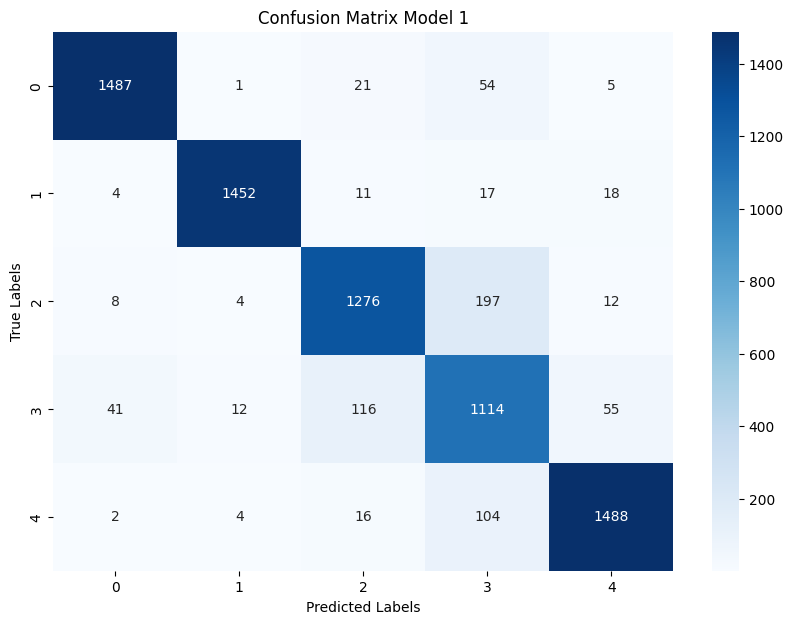

In [83]:
print('Model 1 - Classification Report')
y_pred = model1.predict(X_test1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 1')
plt.show()

Model 2 - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1568
           1       0.98      0.98      0.98      1502
           2       0.95      0.85      0.89      1497
           3       0.78      0.88      0.83      1338
           4       0.95      0.96      0.95      1614

    accuracy                           0.93      7519
   macro avg       0.93      0.93      0.93      7519
weighted avg       0.93      0.93      0.93      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


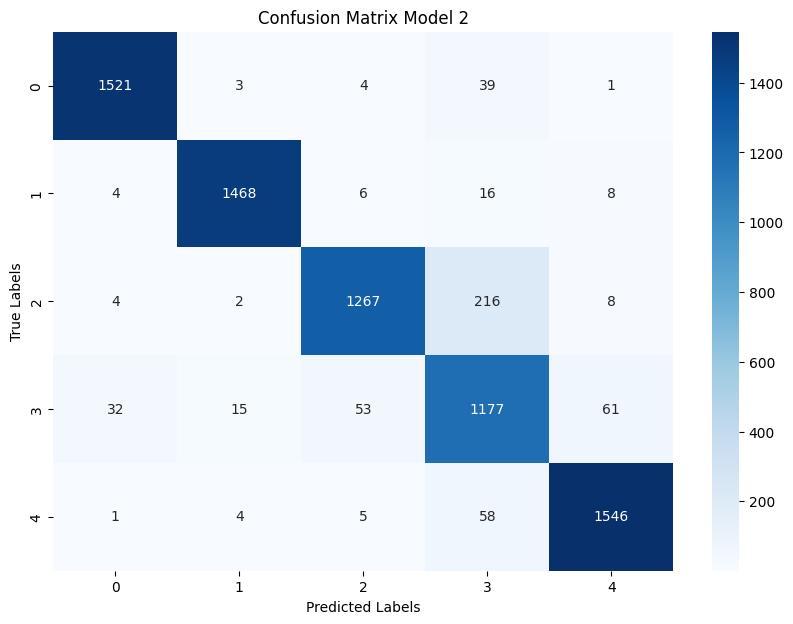

In [84]:
print('Model 2 - Classification Report')
y_pred = model2.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 2')
plt.show()

The second consideration concerns the performance of the different embeddings. These also remain consistent for both dataset 1 and dataset 2. Take, for example, dataset 1, and observe how the baseline behaves with different embeddings. As is often the case, the model performs better with GloVe embeddings than with FastText embeddings.

In [17]:
model1 = tf.keras.models.load_model('Models/LSTM/pre_baseline_200.h5')
model2 =  tf.keras.models.load_model('Models/LSTM/pre_baseline_50.h5')
model3 = tf.keras.models.load_model('Models/LSTM/pre_baseline_100.h5')

In [18]:
test_loss, test_accuracy = model1.evaluate(X_test1, y_test1)
print(f'Test Loss Model 200: {test_loss}')
print(f'Test Accuracy Model 200: {test_accuracy}')
print()

test_loss, test_accuracy = model2.evaluate(X_test1, y_test1)
print(f'Test Loss Model 50: {test_loss}')
print(f'Test Accuracy Model 50: {test_accuracy}')
print()

test_loss, test_accuracy = model3.evaluate(X_test1, y_test1)
print(f'Test Loss Model 100: {test_loss}')
print(f'Test Accuracy Model 100: {test_accuracy}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.9016 - loss: 0.3352
Test Loss Model 200: 0.35827115178108215
Test Accuracy Model 200: 0.8937358856201172

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8663 - loss: 0.4441
Test Loss Model 50: 0.462555468082428
Test Accuracy Model 50: 0.8583588004112244

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8204 - loss: 0.5772
Test Loss Model 100: 0.6010579466819763
Test Accuracy Model 100: 0.8103471398353577


Model 200 - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1568
           1       0.96      0.95      0.95      1502
           2       0.90      0.82      0.86      1497
           3       0.73      0.83      0.78      1338
           4       0.93      0.92      0.92      1614

    accuracy                           0.89      7519
   macro avg       0.89      0.89      0.89      7519
weighted avg       0.90      0.89      0.90      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


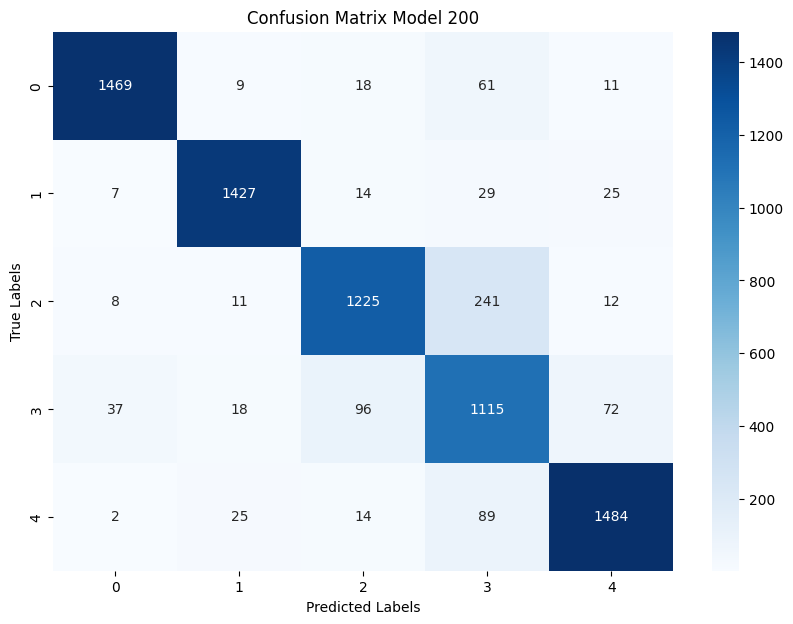

In [19]:
print('Model 200 - Classification Report')
y_pred = model1.predict(X_test1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 200')
plt.show()

Model 50 - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1568
           1       0.93      0.89      0.91      1502
           2       0.84      0.77      0.80      1497
           3       0.68      0.81      0.74      1338
           4       0.89      0.89      0.89      1614

    accuracy                           0.86      7519
   macro avg       0.86      0.86      0.86      7519
weighted avg       0.87      0.86      0.86      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


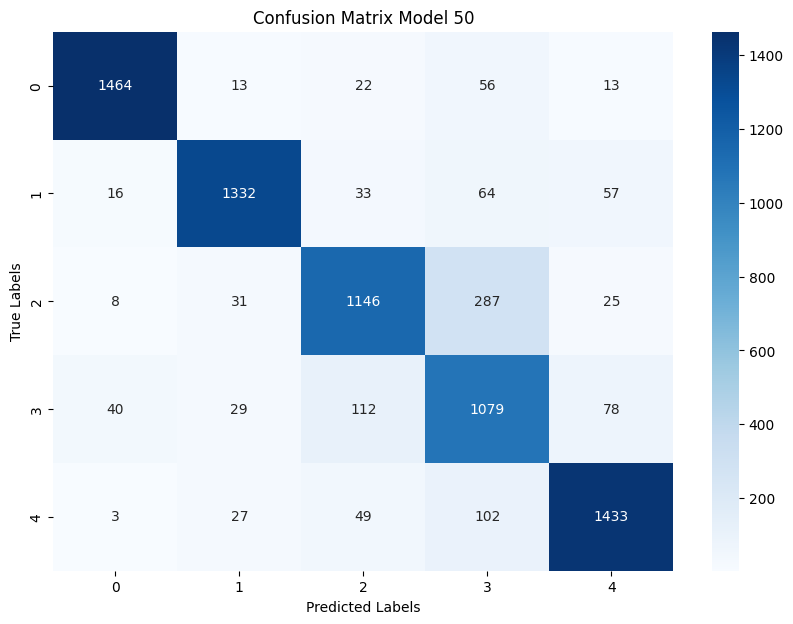

In [20]:
print('Model 50 - Classification Report')
y_pred = model2.predict(X_test1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 50')
plt.show()

Model 100 - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1568
           1       0.92      0.85      0.89      1502
           2       0.89      0.67      0.76      1497
           3       0.56      0.83      0.67      1338
           4       0.83      0.77      0.80      1614

    accuracy                           0.81      7519
   macro avg       0.83      0.81      0.81      7519
weighted avg       0.84      0.81      0.82      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


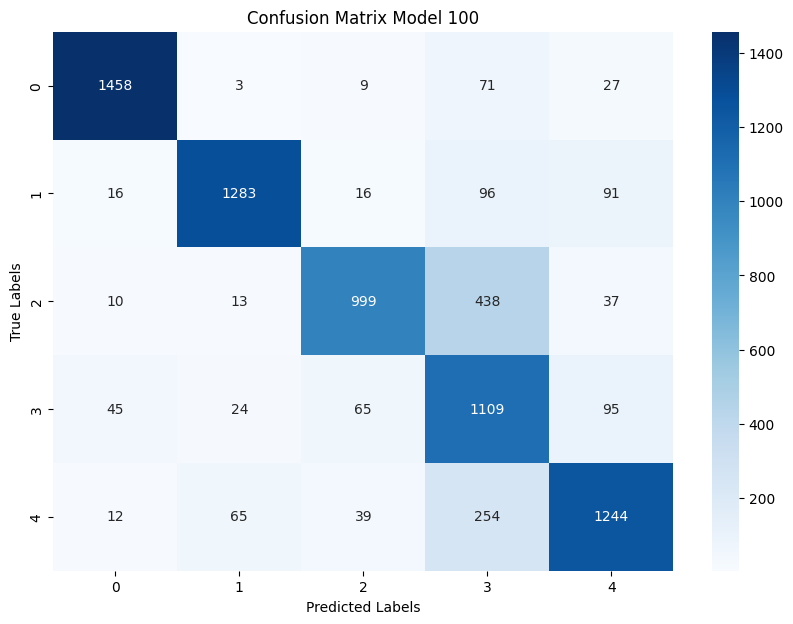

In [21]:
print('Model 100 - Classification Report')
y_pred = model3.predict(X_test1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test1, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test1, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model 100')
plt.show()

The last consideration concerns the different kinds of LSTM architectures that were explored. In this sense, we can see that generally all models reach almost the same accuracy. Adding an attention layer does not seem to improve performance. Let's see an example with three different models trained with 200 GloVe embeddings. 

In [22]:
model1 = tf.keras.models.load_model('Models/LSTM/no_baseline_200.h5')
model2 =  tf.keras.models.load_model('Models/LSTM/no_bidi_200.h5')
model3 = tf.keras.models.load_model('Models/LSTM/no_att_200.h5')

In [23]:
test_loss, test_accuracy = model1.evaluate(X_test2, y_test2)
print(f'Test Loss Model Baseline: {test_loss}')
print(f'Test Accuracy Model Baseline: {test_accuracy}')
print()

test_loss, test_accuracy = model2.evaluate(X_test2, y_test2)
print(f'Test Loss Model Bidirectional: {test_loss}')
print(f'Test Accuracy Model Bidirectional: {test_accuracy}')
print()

test_loss, test_accuracy = model3.evaluate(X_test2, y_test2)
print(f'Test Loss Model Attention: {test_loss}')
print(f'Test Accuracy Model Attention: {test_accuracy}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9233 - loss: 0.2761
Test Loss Model Baseline: 0.28687238693237305
Test Accuracy Model Baseline: 0.9174092411994934

235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.9319 - loss: 0.2556
Test Loss Model Bidirectional: 0.26381582021713257
Test Accuracy Model Bidirectional: 0.9281819462776184

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9277 - loss: 0.2668
Test Loss Model Attention: 0.276534765958786
Test Accuracy Model Attention: 0.9206011295318604


Model Baseline - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1568
           1       0.97      0.96      0.97      1502
           2       0.92      0.84      0.88      1497
           3       0.76      0.86      0.81      1338
           4       0.95      0.95      0.95      1614

    accuracy                           0.92      7519
   macro avg       0.92      0.92      0.92      7519
weighted avg       0.92      0.92      0.92      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


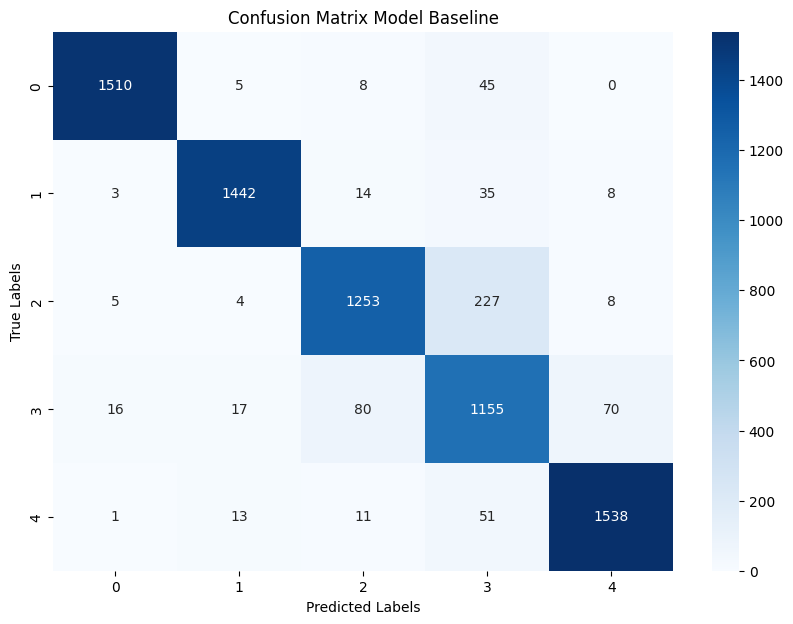

In [24]:
print('Model Baseline - Classification Report')
y_pred = model1.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model Baseline')
plt.show()

Model Bidirectional - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1568
           1       0.98      0.98      0.98      1502
           2       0.95      0.85      0.89      1497
           3       0.78      0.88      0.83      1338
           4       0.95      0.96      0.95      1614

    accuracy                           0.93      7519
   macro avg       0.93      0.93      0.93      7519
weighted avg       0.93      0.93      0.93      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


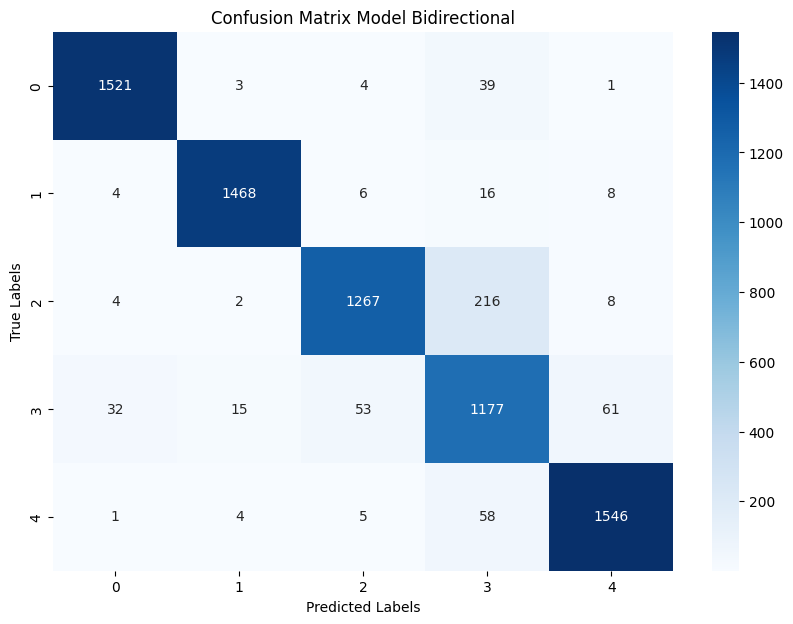

In [25]:
print('Model Bidirectional - Classification Report')
y_pred = model2.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model Bidirectional')
plt.show()

Model Attention - Classification Report
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1568
           1       0.96      0.97      0.97      1502
           2       0.94      0.83      0.88      1497
           3       0.77      0.87      0.82      1338
           4       0.95      0.95      0.95      1614

    accuracy                           0.92      7519
   macro avg       0.92      0.92      0.92      7519
weighted avg       0.92      0.92      0.92      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


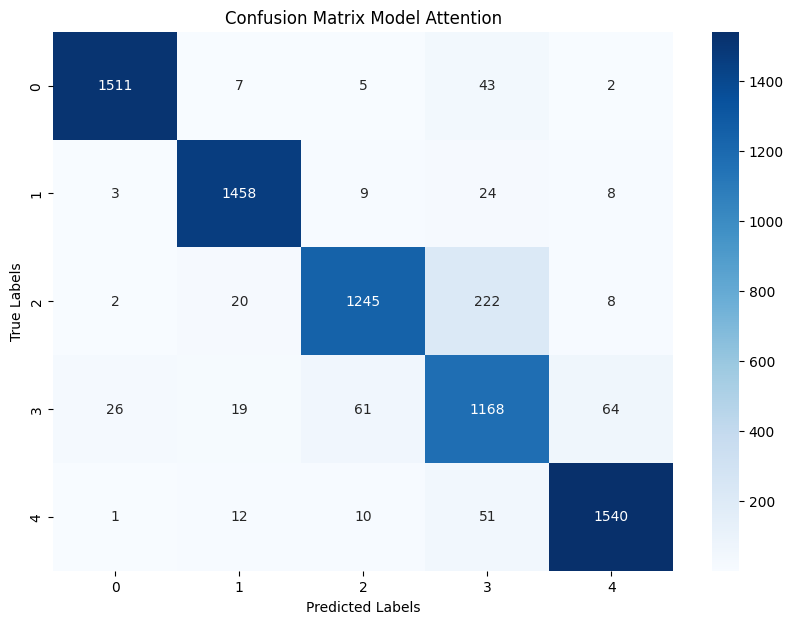

In [26]:
print('Model Attention - Classification Report')
y_pred = model3.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test2, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test2, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Model Attention')
plt.show()